## Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import mode
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

In [5]:
train_data = pd.read_csv(r"C:\Users\PRIYANKA\Desktop\Pushya\train_data.csv")
test_data = pd.read_csv(r"C:\Users\PRIYANKA\Desktop\Pushya\test_data.csv")

In [7]:
print(train_data.head())

   travel_mode  TrvlTime_number  Age  indiv_trvl_frequency  HHVeh  HHsize
0            1          761.939   54                    48      3       4
1            1          595.000   64                    28      2       2
2            0          100.000   42                     7      0      10
3            1          360.000   56                   105      3       3
4            1         2275.000   53                    24      2       5


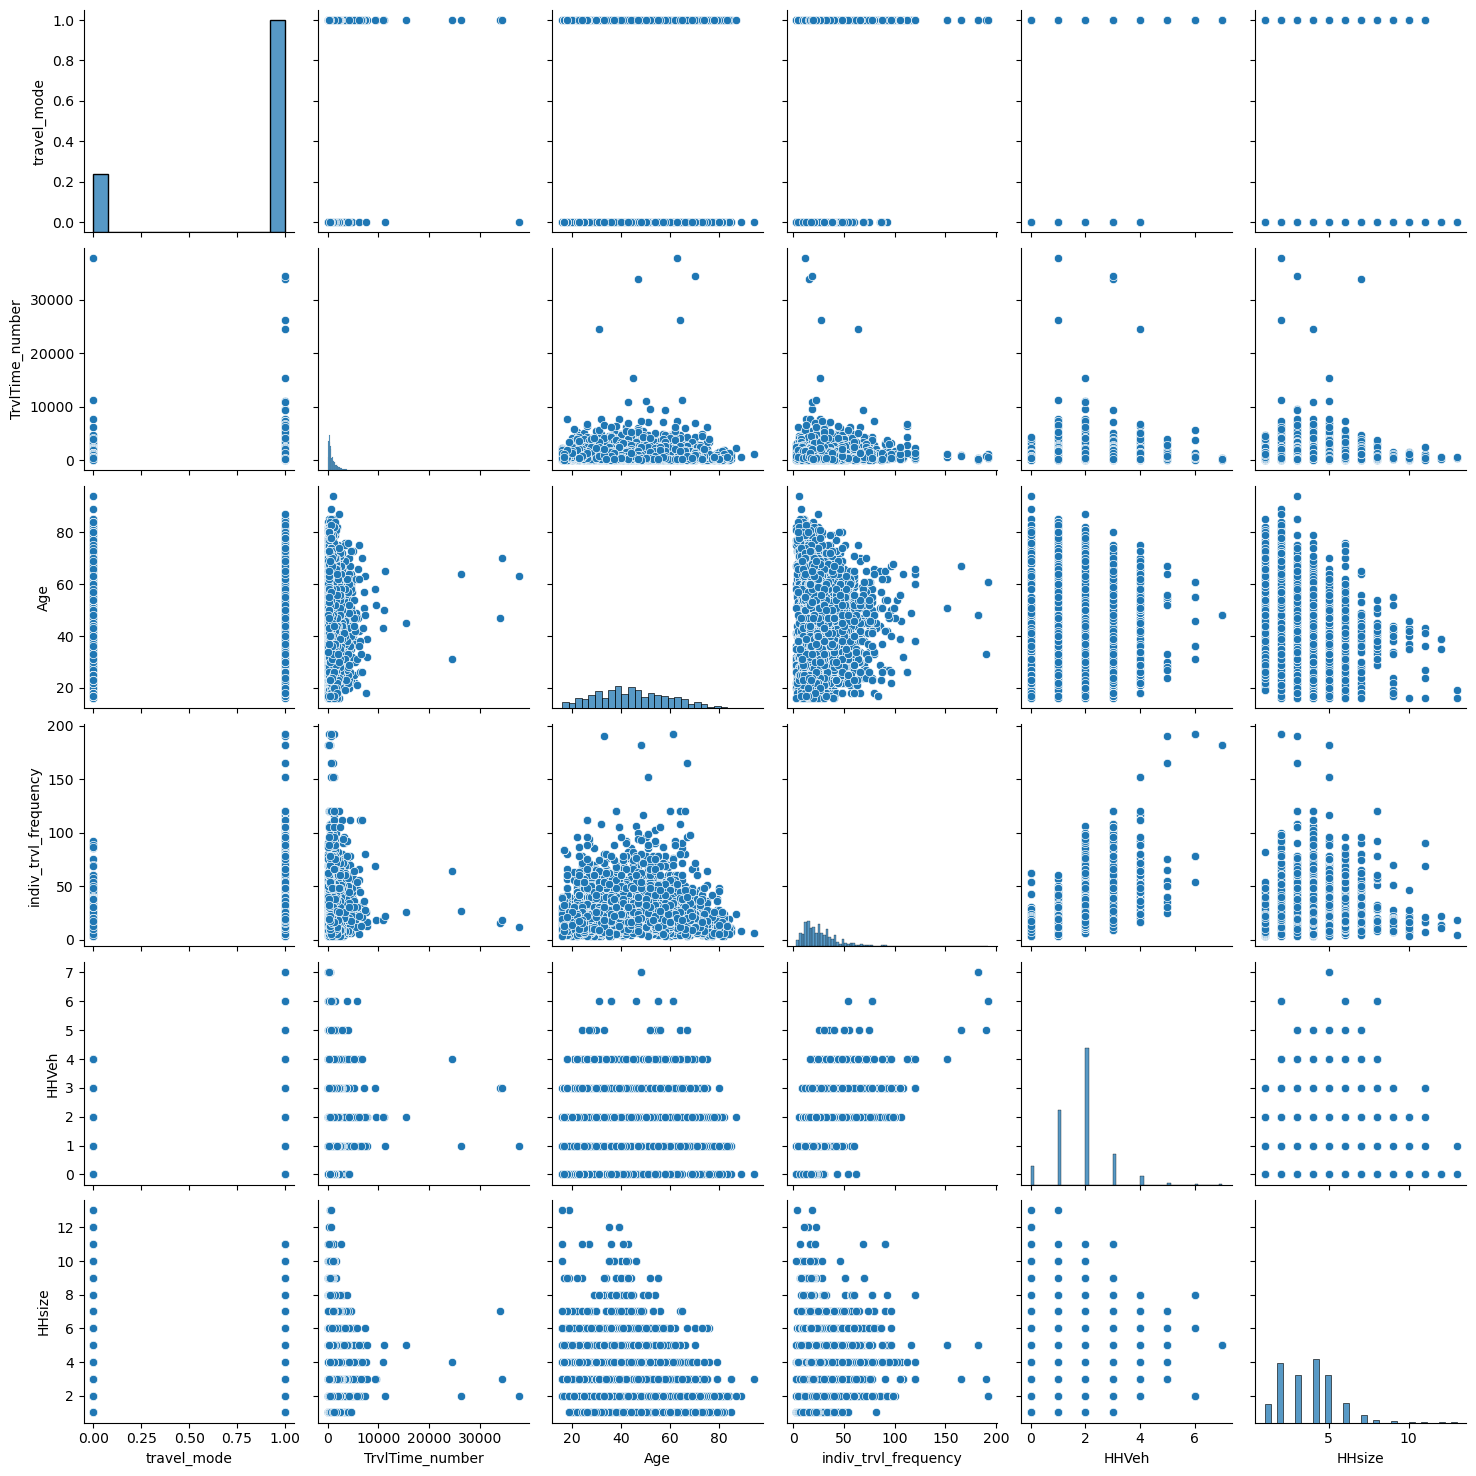

In [9]:
sns.pairplot(train_data)
plt.show()

In [11]:
X_train = train_data.drop('travel_mode', axis=1)
X_test = test_data.drop('travel_mode', axis=1)

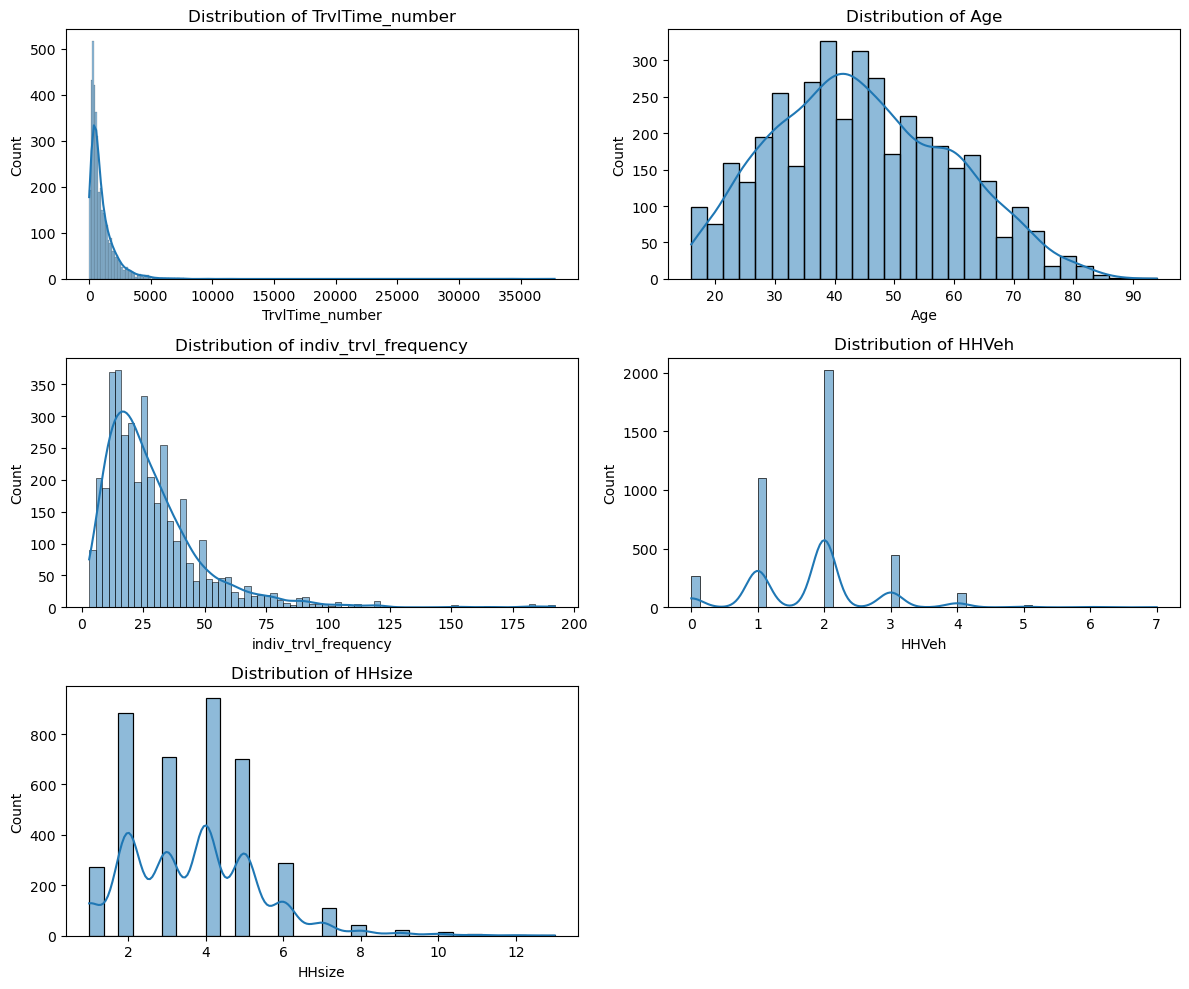

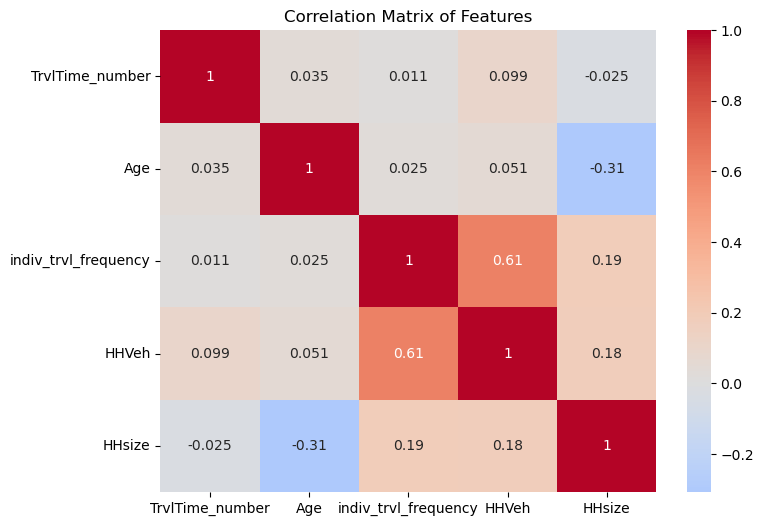

In [13]:
plt.figure(figsize=(12, 10))
for i, column in enumerate(X_train.columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(X_train[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

#correlations
plt.figure(figsize=(8, 6))
sns.heatmap(X_train.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Features')
plt.show()

### Interpretation:
1. Travel Time: Highly right-skewed,most trips are short, with few longer trips.
2. Age: Approximately normal distribution, middle age individuals are the major travelers.
3. Individual Travel Frequency: Right-skewed, most people travel fewer than 30 times, indicating non-frequency of travel.
4. Household Vehicle Ownership (HHVeh): most households own one or two vehicles!
5. Household Size (HHsize): Bimodal with 2 peaks, indicating common household size.

A slight positive correlation exists between individual travel frequency and household vehicle count, aligning 
with common understanding . Multicollinearity isn't significantindicating independency of variables.ty.

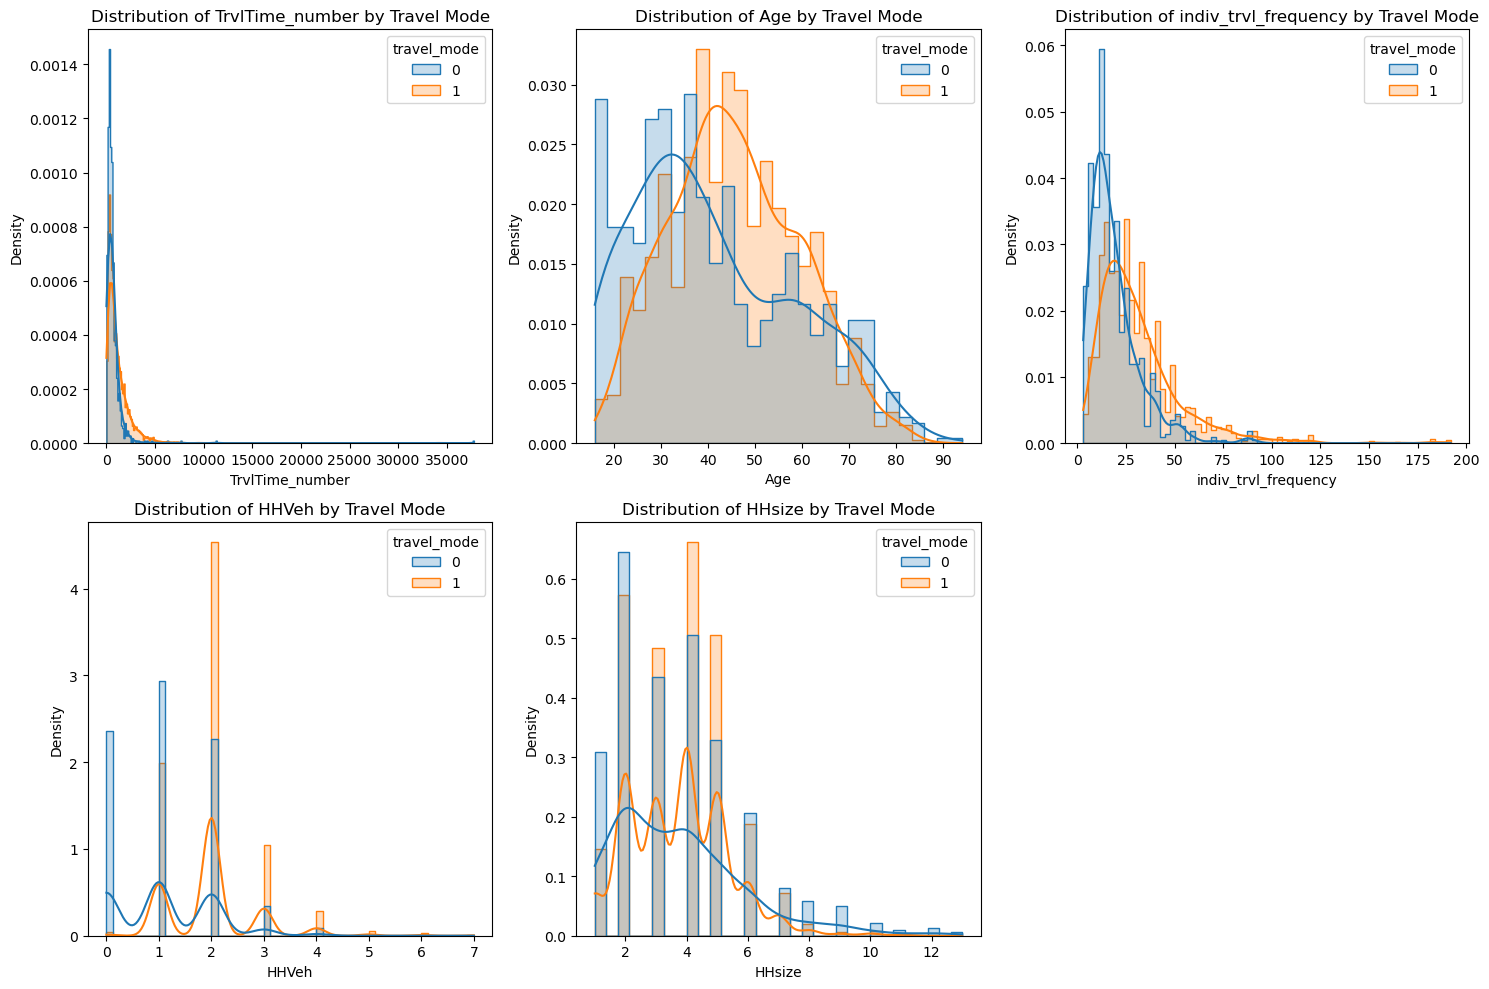

In [21]:
#To visualise together
features = ['TrvlTime_number', 'Age', 'indiv_trvl_frequency', 'HHVeh', 'HHsize']
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(data=train_data, x=feature, hue='travel_mode', kde=True, element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {feature} by Travel Mode')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Interpretation:
Travel Time: Both modes show skewed distributions and car trips have longer durations.
Age: Car travelers are slightly older than walkers.
Travel Frequency: Walkers tend to travel more frequently.
Household Vehicle Ownership: More vehicles are associated with car travel.
Household Size: Smaller households prefer walking whereas larger ones use cars.

## Data Preprocessing

In [32]:
#Standardise data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#PCA with 90% variance
pca = PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [38]:
print(f'Number of PCA to explain 90% of variation: {pca.n_components_}')

Number of PCA to explain 90% of variation: 4


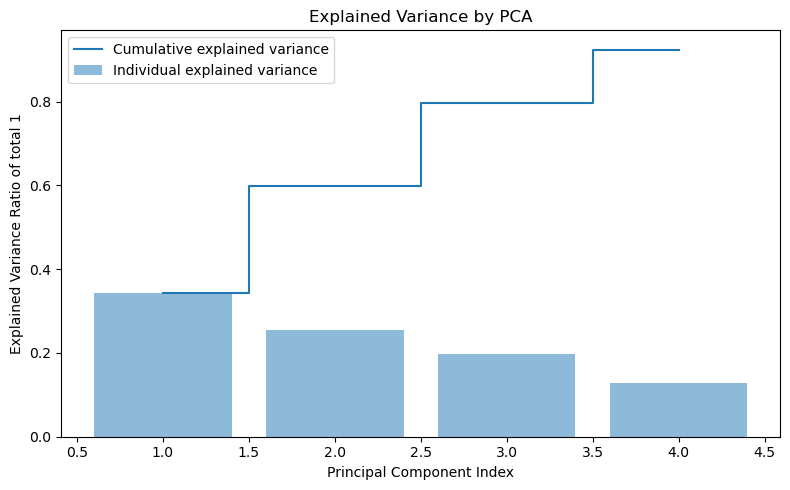

In [46]:
# Variance explained by each PCA
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio of total 1')
plt.title('Explained Variance by PCA')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Model Building and Evaluation

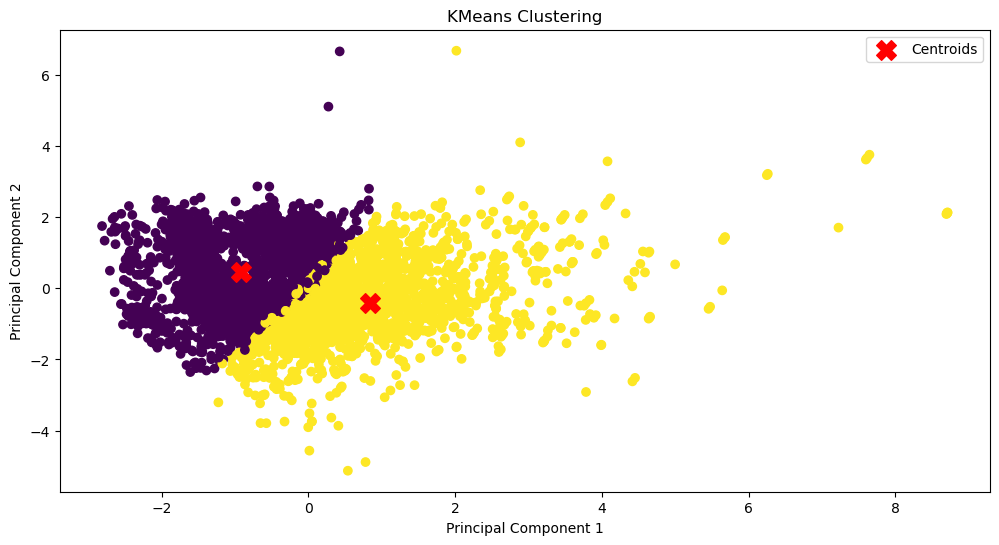

In [69]:
#K Means Clustering

kmeans = KMeans(n_clusters=2, random_state=0, n_init=10)
kmeans.fit(X_train_pca)
kmeans_labels = kmeans.labels_

plt.figure(figsize=(12, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

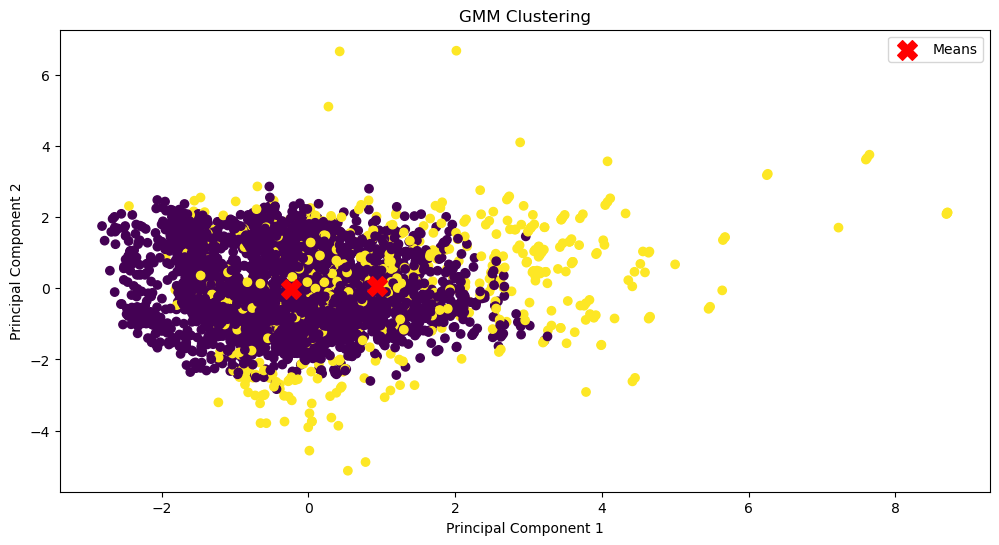

In [71]:
#GMM Clustering

gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(X_train_pca)
gmm_labels = gmm.predict(X_train_pca)

plt.figure(figsize=(12, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=gmm_labels, cmap='viridis')
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=200, c='red', marker='X', label='Means')
plt.title('GMM Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [77]:
y_train = train_data['travel_mode']
y_test = test_data['travel_mode']

Car_mode = 1

In [79]:
def evaluate_model(cluster_model, X_train, y_train, X_test, y_test):
    label_mapping = get_label_mapping(cluster_model, X_train, y_train)

    # One cluster should be mapped as car mode
    if Car_mode not in label_mapping.values():
        return 0, 0, 0  #return 0 if there are no clusters of car_mode

    # predictions on test
    test_cluster = cluster_model.predict(X_test)
    test_predictions = [label_mapping[label] for label in test_cluster]

    # predictions with respect to car mode
    accuracy = accuracy_score(y_test, test_predictions)
    precision = precision_score(y_test, test_predictions, pos_label=Car_mode)
    recall = recall_score(y_test, test_predictions, pos_label=Car_mode)

    return accuracy, precision, recall

In [81]:
def get_label_mapping(cluster_model, data, original_labels):
    cluster_labels = cluster_model.predict(data)
    label_mapping = {}

    for cluster_label in np.unique(cluster_labels):
        original_labels_in_cluster = original_labels[cluster_labels == cluster_label]

        mode_result = mode(original_labels_in_cluster, axis=None)

        if np.isscalar(mode_result.mode):
            original_label = mode_result.mode.item()
        else:
            original_label = mode_result.mode[0]

        label_mapping[cluster_label] = original_label

    return label_mapping

In [87]:
kmeans_accuracy, kmeans_precision, kmeans_recall = evaluate_model(kmeans, X_train_pca, train_data['travel_mode'], X_test_pca, y_test)
print(f"KMeans Accuracy: {kmeans_accuracy:.3f}")
print(f"KMeans Precision: {kmeans_precision:.3f}")
print(f"KMeans Recall: {kmeans_recall:.3f}")

KMeans Accuracy: 0.807
KMeans Precision: 0.807
KMeans Recall: 1.000


In [89]:
gmm_accuracy, gmm_precision, gmm_recall = evaluate_model(gmm, X_train_pca, train_data['travel_mode'], X_test_pca, y_test)
print(f"\nGMM Accuracy: {gmm_accuracy:.3f}")
print(f"GMM Precision: {gmm_precision:.3f}")
print(f"GMM Recall: {gmm_recall:.3f}")


GMM Accuracy: 0.807
GMM Precision: 0.807
GMM Recall: 1.000


In [91]:
print("Model Comparison:")
print(f"K-Means: Accuracy = {kmeans_accuracy:.2f}, Precision = {kmeans_precision:.2f}")
print(f"GMM: Accuracy = {gmm_accuracy:.2f}, Precision = {gmm_precision:.2f}")

Model Comparison:
K-Means: Accuracy = 0.81, Precision = 0.81
GMM: Accuracy = 0.81, Precision = 0.81


### Interpretation:
1. K-Means: sum of squared errors.
2. Gaussian Matrix: average log-likelihood.
   
K-Means shows clearer cluster boundaries in 2D scatterplots, overlapping clusters are expected and GMM can handle different shapes and sizes of clusters. But in summary, both models perform similarly. 